# Theoretical associated kernel estimation
This file contains the code to generate the plots of the article "Non-parametric hazard rate estimation with associated kernels
and minimax bandwidth choice." by L. Breuil and S. Kaakai

In [29]:
#Importing libraries
library(ggplot2)
library('IBMPopSim')
library(viridis)
library('logKDE')
library('TeachingDemos')

source('Kernel_estimation_article.R')#R file with base functions

mycol <- rgb(128, 128, 128, max = 255, alpha = 75, names = "lt.grey")
col_pop =  rgb(red = 0.5,green = 0.5, blue = 0.5,alpha = 0.06)

The goal of hazard rate estimation is to estimate, from the jumping times $(\tau_i)_{1\leq i \leq m}$, the hazard rate $k$ associated to these jumping times on $\mathbb{R}_+$.
In order to estimate a hazard rate $k$ of the data $(\tau_i)_{1\leq i \leq m}$ at a given point $t$, one considers the following kernel estimator 
\begin{equation}
   \hat{k}_m(t) =  \sum_{i\geq 1} \frac{1}{m-C_{\tau_i}} \kappa_{t,b}(\tau_i),
\end{equation}
where 
\begin{equation}
    C_t = \sum_{i=1}^{m} \mathbb{1}_{( \tau_i < t)}.
\end{equation}

# I. Kernel presentation

The Gaussian kernel is defined for $b>0$, $y,t \in \mathbb{R}$, 

\begin{equation}
        \kappa_{t,b}(y) = \frac{1}{\sqrt{2 \pi} b} e^{-\frac{(t-y)^2}{2b^2}}
\end{equation}

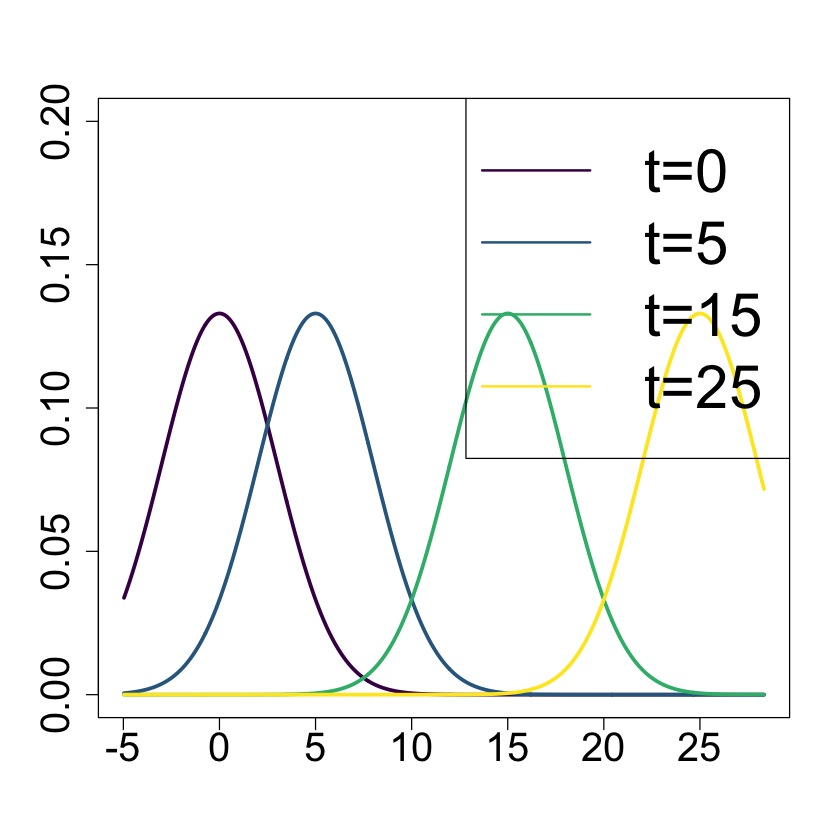

In [2]:
#Plot of the gaussian kernel for different values of t

#pdf(file = "Gauss_kernel.pdf",  width = 10, height = 10) 

T = (1:1000)/30 -5 #grid for y
h = 3 #bandwidth
y = c(0,5,15,25) #times t on which the kernel depends
col_plot = viridis(length(y)) #colors for plot 

plot(T,1/h*dnorm((T-y[1])/h, 0 , 1) , type = 'l' , col= col_plot[1] ,lwd= 3,xlab=NA,ylab =NA,ylim=c(0,0.2),cex.axis = 2, cex.lab =2 )   
lines(T,1/h*dnorm((T-y[2])/h, 0 , 1), col= col_plot[2],lwd=3 )   
lines(T,1/h*dnorm((T-y[3])/h, 0 , 1), col= col_plot[3] ,lwd=3)   
lines(T,1/h*dnorm((T-y[4])/h, 0 , 1) , col= col_plot[4] ,lwd=3)   
legend('topright',legend=c('t=0','t=5','t=15', 't=25'),
        col=col_plot, pch=NA,lty = 1,lwd=2,cex=3)
#dev.off()

The Gamma kernel is defined for $b>0$, $y,t \in \mathbb{R}_+$, 
\begin{equation}
        \kappa_{t,b}(y) = \frac{y^{\rho(t)_b - 1}e^{-y/b}}{b^{\rho(t)_b}\Gamma(\rho(t)_b)} 
    \end{equation}
    where 
    \begin{equation}
    \rho(t)_b = 
    \begin{cases}
         &t/b \text{ if } t \geq 2b\\
         &\frac{1}{4}(t/b)^2 + 1  \text{ if } 0 \leq t < 2b.
    \end{cases}
    \end{equation}

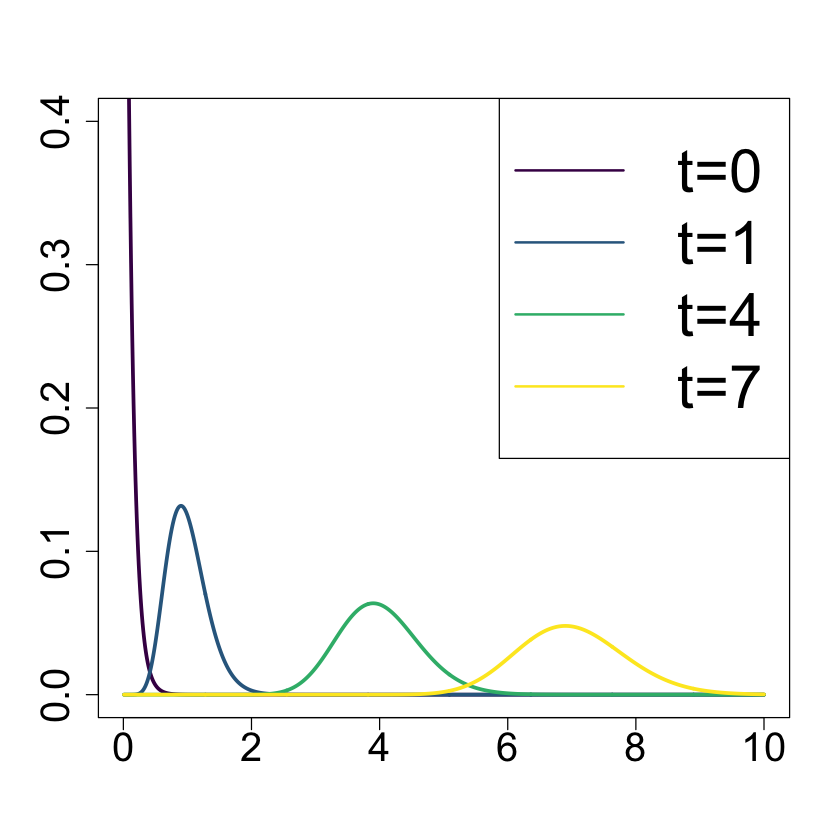

In [3]:
#Plot of the gamma kernel for different values of t

#pdf(file = "Gamma_kernel.pdf",  width = 10, height = 10) 

T = (1:1000)/100 #grid for y
h = 0.1 #bandwidth
y = c(0,1,4,7) #times t on which the kernel depends
col_plot = viridis(length(y)) #colors for plot

#intermediate arrays to compute the gamma kernel
indices = (y >= 2*h)
y_new = y/h*indices + (1/4*(y/h)^2 + 1)*(!indices)

plot(T,h*dgamma(T, y_new[1] , scale = h) , type = 'l' , col= col_plot[1] ,lwd= 3,xlab=NA,ylab =NA ,ylim = c(0,0.4),cex.axis = 2, cex.lab =2)   
lines(T,h*dgamma(T, y_new[2], scale = h), col= col_plot[2],lwd=3 )   
lines(T,h*dgamma(T, y_new[3] , scale = h), col= col_plot[3] ,lwd=3)   
lines(T,h*dgamma(T, y_new[4] , scale = h) , col= col_plot[4] ,lwd=3)   
legend('topright',legend=c('t=0','t=1','t=4', 't=7'),
        col=col_plot, pch=NA,lty = 1,lwd=2,cex=3)
#dev.off()

# II. Comparing estimators

## Comparison of the Gamma kernel estimator with other estimators on two hazard rates

Global minimax bandwidth: 0.5732641 
Cross-validation bandwidth: 10

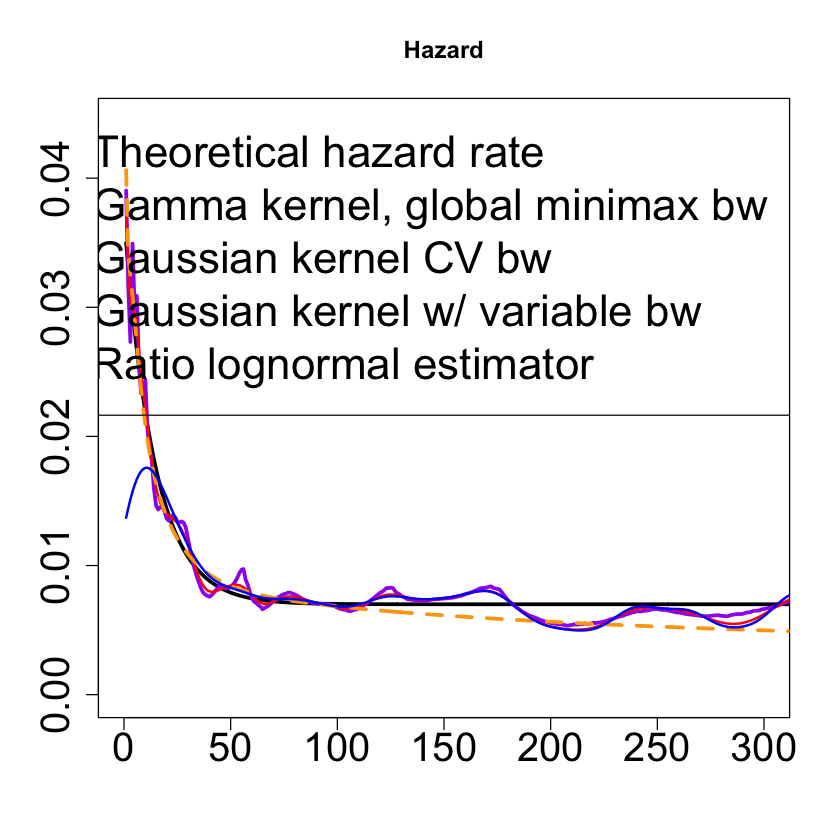

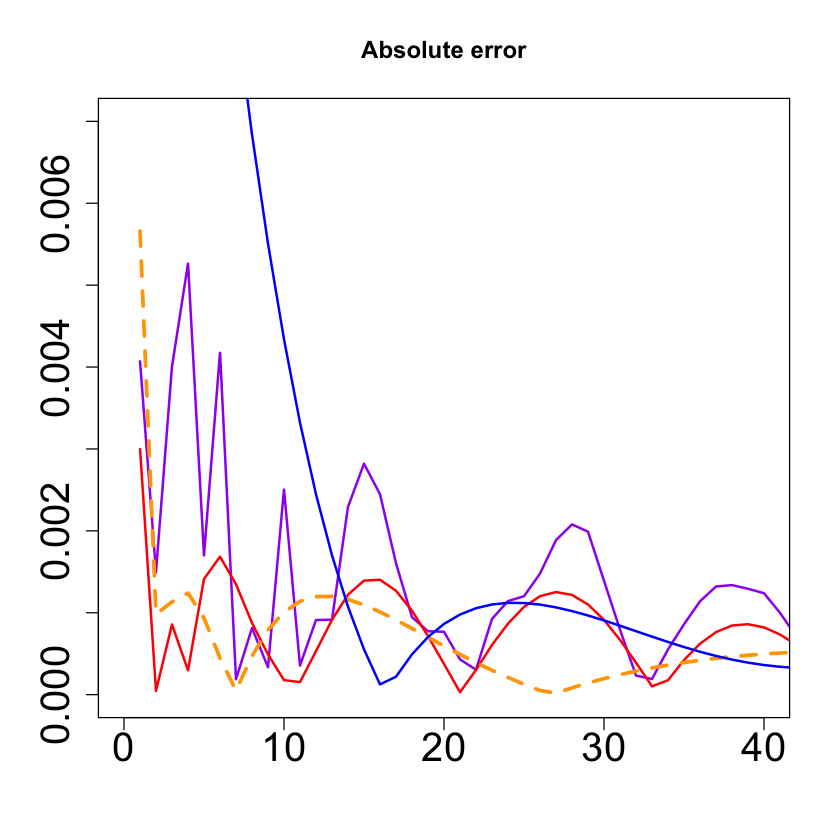

In [3]:
#Comparison of the gamma, gaussian kernel (with fixied and nearest neighbour bandwidth) 
#and lognormal kernel with ratio estimator on a pathological hazard rate
Grid = (1:600)
#death hazard rate is a+b*exp(-c*t)
a = 7*10^(-3)
b = 3*10^(-2)
c = 7*10^(-2)
th_haz = a+b*exp(-c*Grid)
b3 = 0.5 #bandwidth for log estimator
pop_size = 2000 #Simulated population size
param = list('a' = a, 'b' = b, 'c' = c) 
hazard = '{result = a+b*exp(-c*pow(I.age(t),1));}'
seed=1

#Global estimators 
B1 = Bandwidth_set_global(pop_size) #bandwidth set for global minimax bandwidth 
RES = minimax_global(param, hazard, pop_size ,  Grid, B1,seed)
Bopt_f = RES$B #chosen bandwidth
TD_f = RES$T #simulated data
cat('Global minimax bandwidth:', Bopt_f,'\n')
est_gam_f = sapply(Grid, function(t)(ker_est_gamma_c(t,TD_f,Bopt_f))) #global minmax bandwidth gamma estimator
CV_gs=crossval(sort(TD_f),(1:10),ker_estg,1) #cross-validation for gaussian kernel
b_gs = which.min(CV_gs) #minimizer of cross-validation for gaussian kernel 
cat('Cross-validation bandwidth:',b_gs)
est_gaus = sapply(Grid, function(t)(ker_estg(t,TD_f,b_gs))) #gaussian kernel estimator         
est_log = sapply(Grid, function(x)(log_ker_dens(x,b3,TD_f))) #lognormal kernel estimator of density
Surv_log = 1- sapply(Grid, function(x)(est_surv(x,b3,TD_f))) # empirical survival function for lognormal kernel ratio estimation

#Local estimators                 
B = Bandwidth_set(pop_size)  #bandwidth set for local minimax bandwidth 
RES = minimax_pointwise(param, hazard, pop_size ,  Grid, B,seed)
K_gamma_l = RES$K #adaptive hazard estimator
Bopt_l = RES$B #chosen bandwidth
TD_l = RES$T #simulated data
                 
est_band = sapply(Grid, function(x)(ker_est_neigh(x,TD_l,50))) #nearest neighbour bandwidth gaussian kernel estimator    
#pdf(file = "Comp_ker_1_l.pdf",  width = 20, height = 10)  

#par(mfrow = c(1,2),cex.lab = 2, cex.axis = 2,cex.main = 2)

#Plot 2
plot(Grid, th_haz,lwd=3,type = 'l',lty=1, col = 'black',xlab = NA,
      ylab=NA,xlim=c(0,300), ylim = c(0,1.2*(a+b)),cex.axis=2,cex.lab=2,main = 'Hazard')
lines(Grid, est_band,col = 'purple',lwd = 3,lty=1,type = 'l')
lines(Grid, est_gam_f, col = 'red',lwd = 2,lty=1)
lines(Grid, est_log/Surv_log, col = 'orange',lwd = 3,lty=2)
lines(Grid, est_gaus, col = 'blue',lwd = 2,lty=1)

legend('topright',legend=c('Theoretical hazard rate','Gamma kernel, global minimax bw ','Gaussian kernel CV bw',
                           'Gaussian kernel w/ variable bw','Ratio lognormal estimator'),# 'Experimental survival function'),
        col=c('black','red','blue','purple','orange'), pch=c(NA,NA,NA,NA),lty = c(1,1,1,1,2),lwd=3,cex=2.2)


plot(Grid, (abs(est_band-th_haz)),col = 'purple',lwd = 2,lty=1,type = 'l',xlab = NA,
      ylab=NA,xlim=c(0,40),cex.axis=2,cex.lab=2,main = 'Absolute error',ylim=c(0,0.007))
lines(Grid, (abs(est_gam_f-th_haz)), col = 'red',lwd = 2,lty=1)
lines(Grid, (abs(est_log/Surv_log-th_haz)), col = 'orange',lwd = 3,lty=2)
lines(Grid, (abs(est_gaus-th_haz)), col = 'blue',lwd = 2,lty=1)
           
#dev.off() 

Global minimax bandwidth: 0.006299605 
Cross-validation bandwidth: 10

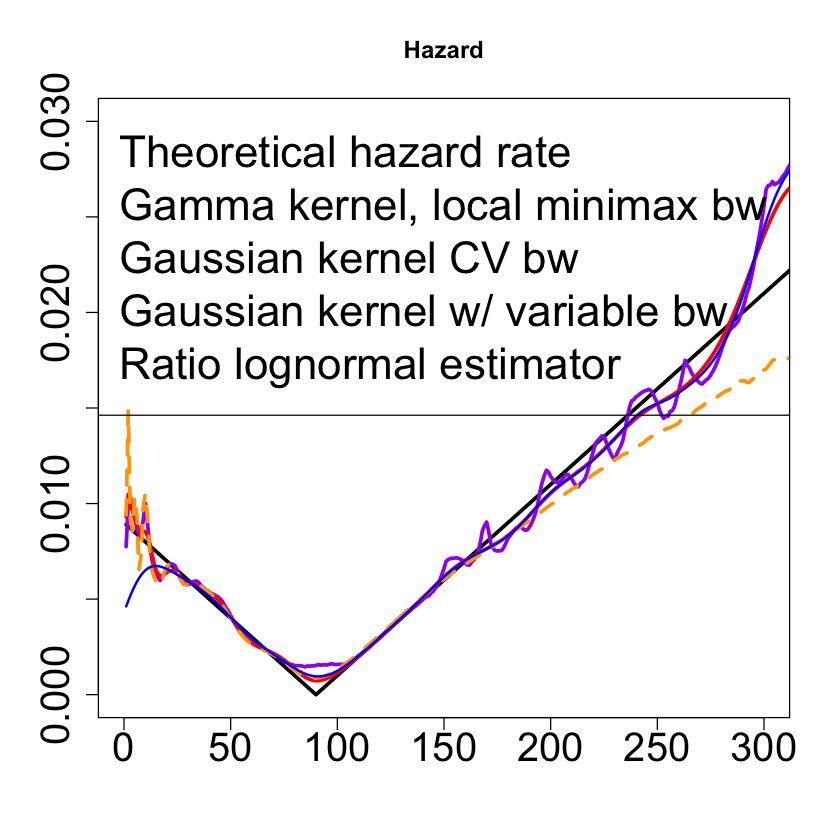

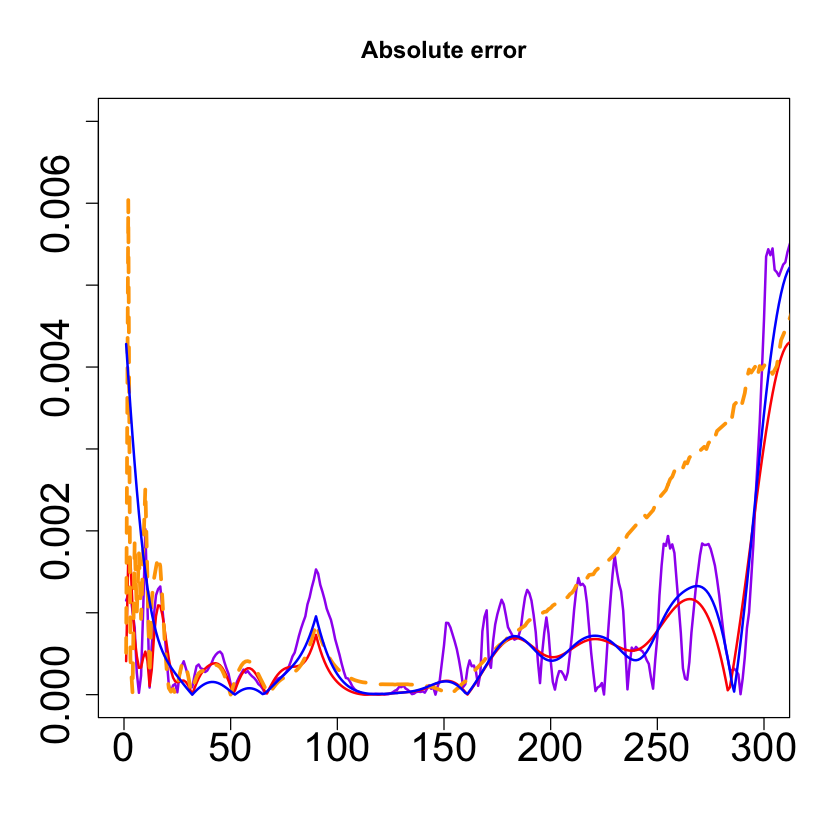

In [7]:
#Comparison of the gamma, gaussian kernel (with fixed and nearest neighbour bandwidth) 
#and lognormal kernel with ratio estimator on a pathological hazard rate

Grid = (1:600)
#death hazard rate is abs(b2*(t/d2 -c2))/a2
a2 = 100
b2 = 3*10^(-2)
c2 = 30
d2 = 3
param2 = list('a2' = a2,'b2' = b2,'c2' = c2,'d2' = d2) 
hazard2 = '{result = b2*abs(I.age(t)/d2 - c2)/a2;}'
th_hazv = abs(b2*(Grid/d2-c2))/a2
b3 = 0.1 #bandwidth for log estimator
pop_size = 2000 #Simulated population size

seed=1

#Global estimators 
B1 = Bandwidth_set_global(pop_size)  #bandwidth set for global minimax bandwidth 
RES = minimax_global(param2 , hazard2, pop_size ,  Grid, B1,seed)
Bopt_f = RES$B #chosen bandwidth
TD_f = RES$T #simulated data
cat('Global minimax bandwidth:', Bopt_f,'\n')
est_gam_f = sapply(Grid, function(t)(ker_est_gamma_c(t,TD_f,Bopt_f))) #gamma kernel estimator global minimax bandwidth choice
CV_gs=crossval(sort(TD_f),(1:10),ker_estg,1) #cross-validation gaussian kernel
b_gs = which.min(CV_gs) #minimizer of cross-validation for gaussian kernel
cat('Cross-validation bandwidth:',b_gs)
est_gaus = sapply(Grid, function(t)(ker_estg(t,TD_f,b_gs))) #gaussian kernel estimator         
est_log = sapply(Grid, function(x)(log_ker_dens(x,b3,TD_f))) #lognormal kernel estimator of density
Surv_log = 1- sapply(Grid, function(x)(est_surv(x,b3,TD_f))) # empirical survival function for lognormal kernel ratio estimation

#Local estimators                 
B = Bandwidth_set(pop_size) #bandwidth set for local minimax bandwidth 
RES = minimax_pointwise(param2,hazard2 , pop_size ,  Grid, B,seed)   
K_gamma_l = RES$K #adaptive hazard estimator
Bopt_l = RES$B #chosen bandwidth
TD_l = RES$T #simulated data
                 
est_band = sapply(Grid, function(x)(ker_est_neigh(x,TD_l,50))) #nearest neighbour bandwidth gaussian kernel estimator    
#pdf(file = "Comp_ker_C0_1.pdf",  width = 20, height = 10)  

#par(mfrow = c(1,2),cex.lab = 2, cex.axis = 2,cex.main = 2)

#Plot 2
plot(Grid, th_hazv,lwd=3,type = 'l',lty=1, col = 'black',xlab = NA,
      ylab=NA,xlim=c(0,300), ylim = c(0,b),cex.axis=2,cex.lab=2,main = 'Hazard')
lines(Grid, est_band,col = 'purple',lwd = 3,lty=1,type = 'l')
lines(K_gamma_l, col = 'red',lwd = 3,lty=1)
lines(Grid, est_log/Surv_log, col = 'orange',lwd = 3,lty=2)
lines(Grid, est_gaus, col = 'blue',lwd = 2,lty=1)

legend('topright',legend=c('Theoretical hazard rate','Gamma kernel, local minimax bw ','Gaussian kernel CV bw',
                           'Gaussian kernel w/ variable bw','Ratio lognormal estimator'),# 'Experimental survival function'),
        col=c('black','red','blue','purple','orange'), pch=c(NA,NA,NA,NA),lty = c(1,1,1,1,2),lwd=3,cex=2.2)

                  
plot(Grid, (abs(est_band-th_hazv)),col = 'purple',lwd = 2,lty=1,type = 'l',xlab = NA,
      ylab=NA,xlim=c(0,300),cex.axis=2,cex.lab=2,main = 'Absolute error',ylim=c(0,0.007))
lines(Grid, abs(K_gamma_l-th_hazv), col = 'red',lwd = 2,lty=1)
lines(Grid, abs(est_log/Surv_log-th_hazv), col = 'orange',lwd = 3,lty=2)
lines(Grid, (abs(est_gaus-th_hazv)), col = 'blue',lwd = 2,lty=1)
           
#dev.off() 

# III. Comparing bandwidth choice methods for the gamma kernel

In [22]:
#death hazard rate is a1+b1*exp(-c1*t)
a1 = 7*10^(-3)
b1 = 3*10^(-2)
c1 = 7*10^(-2)
param1 = list('a1'= a1, 'b1'=b1, 'c1'= c1) #parameters in list form
Grid = (0:600) #grid 
th_haz = a1+b1*exp(-c1*Grid) #theoretical hazard rate 
reps = 50 #number of repetitions to compute empirical MISE
hazard1 = '{result = a1+b1*exp(-c1*pow(I.age(t),1));}' #theoretical hazard rate expression 
grid_max = 601 #maximum index of Grid for computation of MISE

In [131]:
#Code to compute the empirical MISE for the local minimax bandwidth and nearest neighbour bandwidth, takes a while, 
#the following cell allows to just load the results
compute_data = FALSE #set to TRUE to recompute all of the MISE estimations, takes a few hours 
if (compute_data){
MISE_loc_500 = MISE_approx_local(500, reps ,param1, hazard1,th_haz,Grid,25) #last input is number of neighbours for nearest
#neighbour bandwidth 
MISE_500_mx = rowMeans(MISE_loc_500$mx[1:grid_max,])
MISE_500_nn = rowMeans(MISE_loc_500$nn[1:grid_max,])
MISE_500_mx_0 = rowMeans(MISE_loc_500$mx_0[1:grid_max,])
MISE_500_nn_0 = rowMeans(MISE_loc_500$nn_0[1:grid_max,])

MISE_loc_1000 = MISE_approx_local(1000, reps ,param1, hazard1,th_haz,Grid,40)
MISE_1000_mx = rowMeans(MISE_loc_1000$mx[1:grid_max,])
MISE_1000_nn = rowMeans(MISE_loc_1000$nn[1:grid_max,])
MISE_1000_mx_0 = rowMeans(MISE_loc_1000$mx_0[1:grid_max,])
MISE_1000_nn_0 = rowMeans(MISE_loc_1000$nn_0[1:grid_max,])

MISE_loc_2000 = MISE_approx_local(2000, reps ,param1, hazard1,th_haz,Grid,60)
MISE_2000_mx = rowMeans(MISE_loc_2000$mx[1:grid_max,])
MISE_2000_nn = rowMeans(MISE_loc_2000$nn[1:grid_max,])
MISE_2000_mx_0 = rowMeans(MISE_loc_2000$mx_0[1:grid_max,])
MISE_2000_nn_0 = rowMeans(MISE_loc_2000$nn_0[1:grid_max,])

MISE_loc_4000 = MISE_approx_local(4000, reps ,param1, hazard1,th_haz,Grid,70)
MISE_4000_mx = rowMeans(MISE_loc_4000$mx[1:grid_max,])
MISE_4000_nn = rowMeans(MISE_loc_4000$nn[1:grid_max,])
MISE_4000_mx_0 = rowMeans(MISE_loc_4000$mx_0[1:grid_max,])
MISE_4000_nn_0 = rowMeans(MISE_loc_4000$nn_0[1:grid_max,])
}

In [27]:
MISE_500_mx=rowMeans(read.csv('MISE/MISE_500_mx.csv')[2:(grid_max+1)])
MISE_500_nn=rowMeans(read.csv('MISE/MISE_500_nn.csv')[2:(grid_max+1)])
MISE_500_mx_0=rowMeans(read.csv('MISE/MISE_500_mx_0.csv')[2:(grid_max+1)])
MISE_500_nn_0=rowMeans(read.csv('MISE/MISE_500_nn_0.csv')[2:(grid_max+1)])

MISE_1000_mx=rowMeans(read.csv('MISE/MISE_1000_mx.csv')[2:(grid_max+1)])
MISE_1000_nn=rowMeans(read.csv('MISE/MISE_1000_nn.csv')[2:(grid_max+1)])
MISE_1000_mx_0=rowMeans(read.csv('MISE/MISE_1000_mx_0.csv')[2:(grid_max+1)])
MISE_1000_nn_0=rowMeans(read.csv('MISE/MISE_1000_nn_0.csv')[2:(grid_max+1)])

MISE_2000_mx=rowMeans(read.csv('MISE/MISE_2000_mx.csv')[2:(grid_max+1)])
MISE_2000_nn=rowMeans(read.csv('MISE/MISE_2000_nn.csv')[2:(grid_max+1)])
MISE_2000_mx_0=rowMeans(read.csv('MISE/MISE_2000_mx_0.csv')[2:(grid_max+1)])
MISE_2000_nn_0=rowMeans(read.csv('MISE/MISE_2000_nn_0.csv')[2:(grid_max+1)])

MISE_4000_mx=rowMeans(read.csv('MISE/MISE_4000_mx.csv')[2:(grid_max+1)])
MISE_4000_nn=rowMeans(read.csv('MISE/MISE_4000_nn.csv')[2:(grid_max+1)])
MISE_4000_mx_0=rowMeans(read.csv('MISE/MISE_4000_mx_0.csv')[2:(grid_max+1)])
MISE_4000_nn_0=rowMeans(read.csv('MISE/MISE_4000_nn_0.csv')[2:(grid_max+1)])

In [28]:
#Printing out results
print('500 ')
cat(' minimax: ',mean(MISE_500_mx),' ',sd(MISE_500_mx),' minimax 0: ',mean(MISE_500_mx_0),' ', sd(MISE_500_mx_0),'\n')
cat(' nn: ', mean(MISE_500_nn),' ',sd(MISE_500_nn),' nn 0: ', mean(MISE_500_nn_0), ' ', sd(MISE_500_nn_0),'\n')
print('1000')
cat(' minimax: ',mean(MISE_1000_mx),' ',sd(MISE_1000_mx),' minimax 0: ',mean(MISE_1000_mx_0),' ', sd(MISE_1000_mx_0),'\n')
cat(' nn: ', mean(MISE_1000_nn),' ',sd(MISE_1000_nn),' nn 0: ', mean(MISE_1000_nn_0), ' ', sd(MISE_1000_nn_0),'\n')
print('2000')
cat(' minimax: ',mean(MISE_2000_mx),' ',sd(MISE_2000_mx),' minimax 0: ',mean(MISE_2000_mx_0),' ', sd(MISE_2000_mx_0),'\n')
cat(' nn: ', mean(MISE_2000_nn),' ',sd(MISE_2000_nn),' nn 0: ', mean(MISE_2000_nn_0), ' ', sd(MISE_2000_nn_0),'\n')
print('4000')
cat(' minimax: ',mean(MISE_4000_mx),' ',sd(MISE_4000_mx),' minimax 0: ',mean(MISE_4000_mx_0),' ', sd(MISE_4000_mx_0),'\n')
cat(' nn: ', mean(MISE_4000_nn),' ',sd(MISE_4000_nn),' nn 0: ', mean(MISE_4000_nn_0), ' ', sd(MISE_4000_nn_0),'\n')


[1] "500 "
 minimax:  1.058936e-05   1.416117e-05  minimax 0:  0.0005154355   0.0009093185 
 nn:  2.519328e-06   1.0168e-06  nn 0:  0.0003634205   0.0001038924 
[1] "1000"
 minimax:  4.902329e-06   4.332553e-06  minimax 0:  0.0003963873   0.0006420635 
 nn:  1.708933e-06   5.306222e-07  nn 0:  0.0003763252   8.892416e-05 
[1] "2000"
 minimax:  2.90765e-06   1.837141e-06  minimax 0:  0.0003252467   0.0005152173 
 nn:  1.337739e-06   2.8071e-07  nn 0:  0.0003746545   7.776508e-05 
[1] "4000"
 minimax:  1.714725e-06   9.187952e-07  minimax 0:  0.0002785397   0.0004138676 
 nn:  1.216446e-06   2.339212e-07  nn 0:  0.0003706283   7.024551e-05 


In [20]:
#Code to compute the empirical MISE on the total interval and at 0 for the global minimax bandwidth 
#and cross-validation bandwidth, takes a while, the cell after this one allows to just load the results

BW_CV = (1:150)/3 #set of bandwidths for cross validation

compute_data = FALSE #set to TRUE to recompute all of the MISE estimations, takes several hours
if (compute_data){
MISE_glob_500 = MISE_approx_global(500, reps ,param1, hazard1,th_haz,Grid,BW_CV) #last input is bandwidth array for CV bandwidth choice
#neighbour bandwidth 
MISE_500_mx_g = rowMeans(MISE_glob_500$mx_g[1:grid_max,])
MISE_500_cv = rowMeans(MISE_glob_500$cv[1:grid_max,])
MISE_500_mx_g0 = rowMeans(MISE_glob_500$mx_g0[1:grid_max,])
MISE_500_cv_0 = rowMeans(MISE_glob_500$cv_0[1:grid_max,])

MISE_glob_1000 = MISE_approx_global(1000, reps ,param1, hazard1,th_haz,Grid,BW_CV)
MISE_1000_mx_g =rowMeans(MISE_glob_1000$mx_g[1:grid_max,])
MISE_1000_cv = rowMeans(MISE_glob_1000$cv[1:grid_max,])
MISE_1000_mx_g0 =rowMeans( MISE_glob_1000$mx_g0[1:grid_max,])
MISE_1000_cv_0 =rowMeans( MISE_glob_1000$cv_0[1:grid_max,])
    
MISE_glob_2000 = MISE_approx_global(2000, reps ,param1, hazard1,th_haz,Grid,BW_CV)
MISE_2000_mx_g =rowMeans( MISE_glob_2000$mx_g[1:grid_max,])
MISE_2000_cv = rowMeans(MISE_glob_2000$cv[1:grid_max,])
MISE_2000_mx_g0 = rowMeans(MISE_glob_2000$mx_g0[1:grid_max,])
MISE_2000_cv_0 = rowMeans(MISE_glob_2000$cv_0[1:grid_max,])

MISE_glob_4000 = rowMeans(MISE_approx_global(4000, reps ,param1, hazard1,th_haz,Grid,BW_CV)
MISE_4000_mx_g = rowMeans(MISE_glob_4000$mx_g[1:grid_max,])
MISE_4000_cv = rowMeans(MISE_glob_4000$cv[1:grid_max,])
MISE_4000_mx_g0 = rowMeans(MISE_glob_4000$mx_g0[1:grid_max,])
MISE_4000_cv_0 = rowMeans(MISE_glob_4000$cv_0[1:grid_max,])
}

In [12]:
#load results 
MISE_500_mx_g=rowMeans(read.csv('MISE_500_mx_g.csv')[2:(grid_max+1)])
MISE_500_cv=rowMeans(read.csv('MISE_500_cv.csv')[2:(grid_max+1)])
MISE_500_mx_g0=rowMeans(read.csv('MISE_500_mx_g0.csv')[2:(grid_max+1)])
MISE_500_cv_0=rowMeans(read.csv('MISE_500_cv_0.csv')[2:(grid_max+1)])

MISE_1000_mx_g=rowMeans(read.csv('MISE_1000_mx_g.csv')[2:(grid_max+1)])
MISE_1000_cv=rowMeans(read.csv('MISE_1000_cv.csv')[2:(grid_max+1)])
MISE_1000_mx_g0=rowMeans(read.csv('MISE_1000_mx_g0.csv')[2:(grid_max+1)])
MISE_1000_cv_0=rowMeans(read.csv('MISE_1000_cv_0.csv')[2:(grid_max+1)])


MISE_2000_mx_g=rowMeans(read.csv('MISE_2000_mx_g.csv')[2:(grid_max+1)])
MISE_2000_cv=rowMeans(read.csv('MISE_2000_cv.csv')[2:(grid_max+1)])
MISE_2000_mx_g0=rowMeans(read.csv('MISE_2000_mx_g0.csv')[2:(grid_max+1)])
MISE_2000_cv_0=rowMeans(read.csv('MISE_2000_cv_0.csv')[2:(grid_max+1)])


MISE_4000_mx_g=rowMeans(read.csv('MISE_4000_mx_g.csv')[2:(grid_max+1)])
MISE_4000_cv=rowMeans(read.csv('MISE_4000_cv.csv')[2:(grid_max+1)])
MISE_4000_mx_g0=rowMeans(read.csv('MISE_4000_mx_g0.csv')[2:(grid_max+1)])
MISE_4000_cv_0=rowMeans(read.csv('MISE_4000_cv_0.csv')[2:(grid_max+1)])


In [13]:
#print results
print('500 ')
cat(' minimax g: ',mean(MISE_500_mx_g),' ',sd(MISE_500_mx_g),' minimax g0: ',mean(MISE_500_mx_g0),' ', sd(MISE_500_mx_g0),'\n')
cat(' cv: ', mean(MISE_500_cv),' ',sd(MISE_500_cv),' cv 0: ', mean(MISE_500_cv_0), ' ', sd(MISE_500_cv_0),'\n')
print('1000 ')
cat(' minimax g: ',mean(MISE_1000_mx_g),' ',sd(MISE_1000_mx_g),' minimax g0: ',mean(MISE_1000_mx_g0),' ', sd(MISE_1000_mx_g0),'\n')
cat(' cv: ', mean(MISE_1000_cv),' ',sd(MISE_1000_cv),' cv 0: ', mean(MISE_1000_cv_0), ' ', sd(MISE_1000_cv_0),'\n')
print('2000 ')
cat(' minimax g: ',mean(MISE_2000_mx_g),' ',sd(MISE_2000_mx_g),' minimax g0: ',mean(MISE_2000_mx_g0),' ', sd(MISE_2000_mx_g0),'\n')
cat(' cv: ', mean(MISE_2000_cv),' ',sd(MISE_2000_cv),' cv 0: ', mean(MISE_2000_cv_0), ' ', sd(MISE_2000_cv_0),'\n')

[1] "500 "
 minimax g:  6.061562e-06   5.091802e-06  minimax g0:  4.821066e-05   6.130577e-05 
 cv:  5.410298e-06   6.451694e-06  cv 0:  0.0002517074   0.0001866151 
[1] "1000 "
 minimax g:  3.114942e-06   1.652383e-06  minimax g0:  2.838347e-05   4.020061e-05 
 cv:  3.268324e-06   1.629773e-06  cv 0:  0.0002523448   0.0001792553 
[1] "2000 "
 minimax g:  1.844847e-06   9.604647e-07  minimax g0:  2.221601e-05   2.91336e-05 
 cv:  2.561237e-06   1.708363e-06  cv 0:  0.000211877   0.0001800336 


In [17]:
##Test of the local minimax bandwidth estimator on simulated data for different hazard rates
Grid = (0:500)
m=2000 #data size
B = Bandwidth_set(m) 
#parameter values 
a3 = 7*10^(-3)
c3 = 0

hazard3 = '{result = a+ (exp(-pow(I.age(t)-c,2)/(2*pow(b,2)))+exp(-pow(I.age(t)-(c+150),2)/(2*pow(b,2))))/(b*sqrt(2*3.14));}'
seed=8 #seed for reproducability 

#parameter b changes for each hazard rate 
b3 = 15
param3 = list('a' = a3, 'c' = c3,'b' = b3)
th_haz1= dnorm(Grid, c3, b3)+a3 + dnorm(Grid, c3+150, b3) #hazard is a mix of gaussians

RES = minimax_pointwise(param3,hazard3 , m ,  Grid, B,seed) #minimax bandwidth estimator
Koptc1 = RES$K #adaptive hazard estimator
Boptc1 = RES$B #chosen bandwidth
Ttestc1 = RES$T #simulated data

b3 = 5
param3 = list('a' = a3, 'c' = c3,'b' = b3)
th_haz2= dnorm(Grid, c3, b3)+a3 + dnorm(Grid, c3+150, b3)#hazard is a mix of gaussians
RES = minimax_pointwise(param3,hazard3 , m ,  Grid, B,seed)#minimax bandwidth estimator
Koptc2= RES$K
Boptc2 = RES$B
Ttestc2 =RES$T

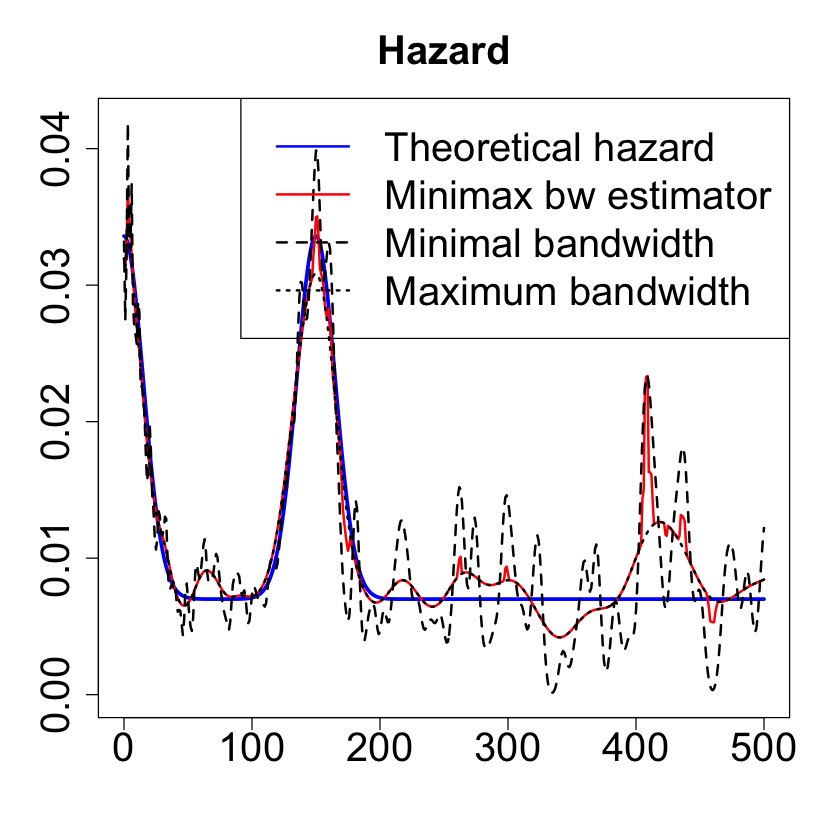

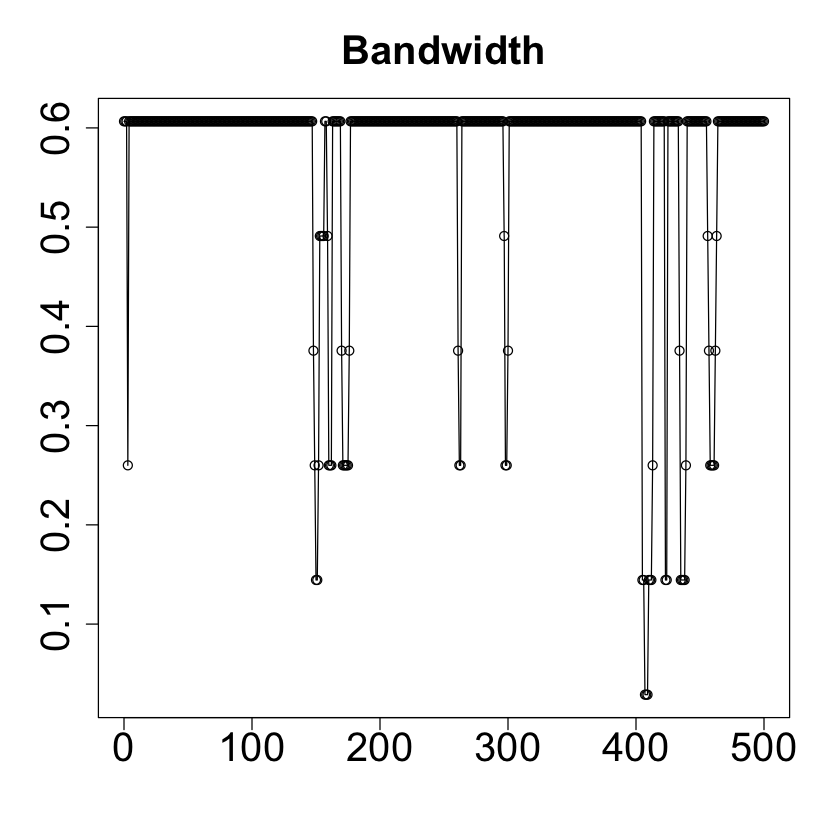

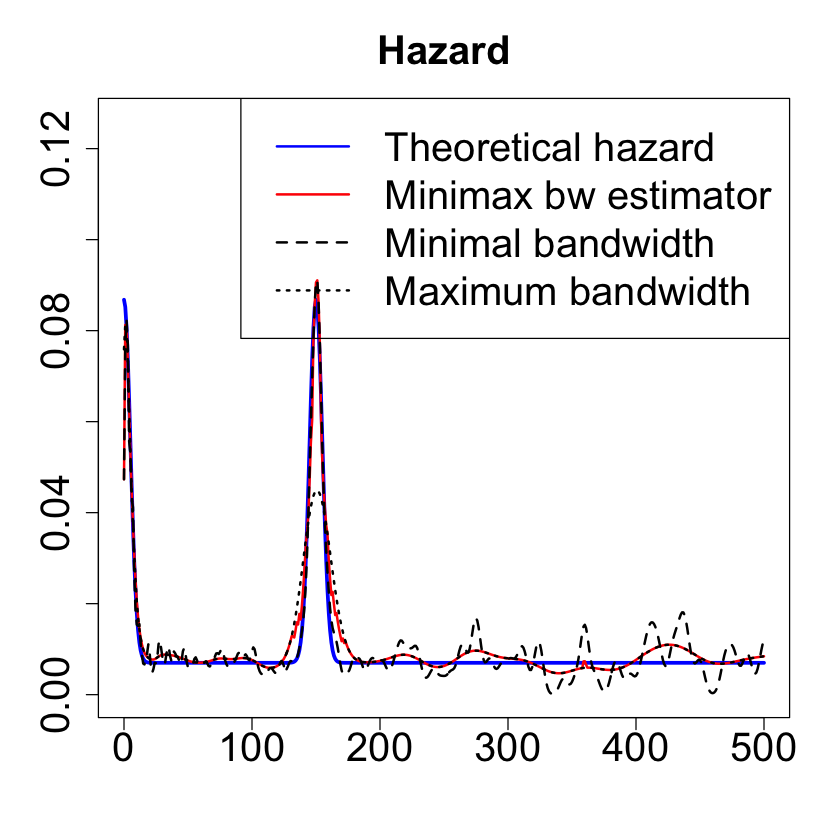

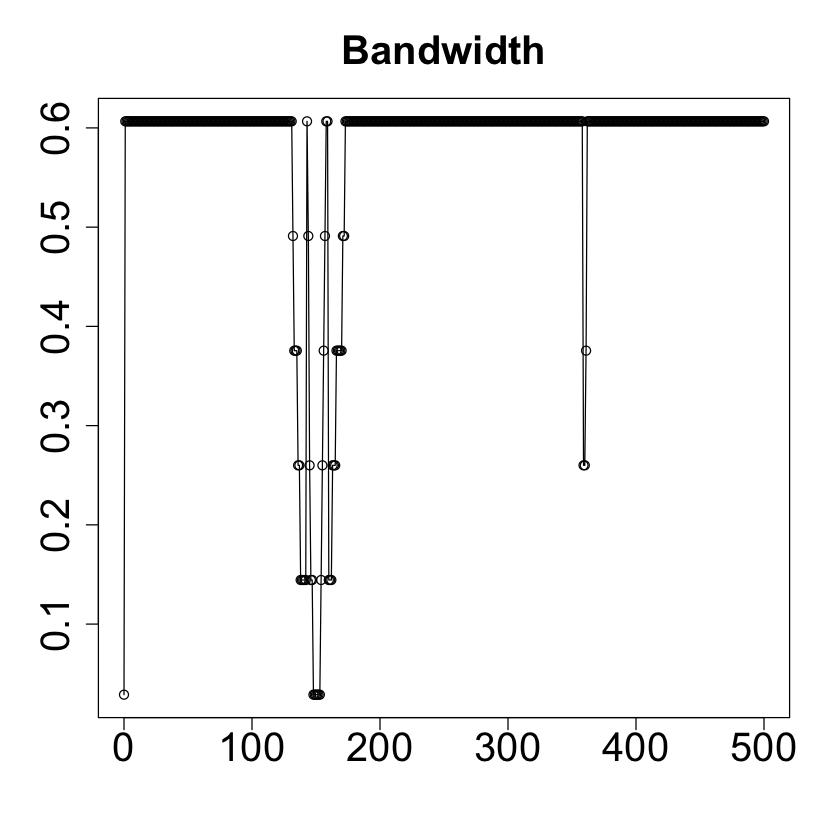

In [18]:
Grid = (0:500)
#pdf(file = "Oracle_diff_haz_2.pdf",  width = 17, height = 5) 

par(cex.lab = 2, cex.axis = 2,cex.main = 2)


#par(mfrow = c(1,4))
plot(Grid, th_haz1,col='blue',lwd=3,type = 'l',lty=1,ylim=c(0,6*a),ylab = NA, main = 'Hazard',xlab = NA)
lines(Grid,Koptc1, type = 'l',col='red',lwd=2)
test = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttestc1,min(B))))
lines(Grid,  test, col='black',lty=2,lwd=2)   
test = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttestc1,max(B))))
lines(Grid,  test, col='black',lty=3,lwd=2)   
legend('topright',legend=c('Theoretical hazard', 'Minimax bw estimator', 'Minimal bandwidth', 'Maximum bandwidth')
       , col=c('blue','red','black','black'), lty = c(1,1,2,3),lwd=2,cex=2)

plot(Grid, Boptc1,xlab =NA, ylab = NA, main = 'Bandwidth')
#subplot(Grid[1:40], Boptc1[1:40],x=c(150,200),y=c(0.033,0.05))
lines(Grid, Boptc1)


c = 7*10^(-1)
plot(Grid, th_haz2,col='blue',lwd=3,type = 'l',lty=1,ylim=c(0,18*a),ylab = NA, main = 'Hazard',xlab = NA)
lines(Grid,Koptc2, type = 'l',col='red',lwd=2)
test = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttestc2,min(B))))
lines(Grid,  test, col='black',lty=2,lwd=2)   
test = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttestc2,max(B))))
lines(Grid,  test, col='black',lty=3,lwd=2)   
legend('topright',legend=c('Theoretical hazard', 'Minimax bw estimator', 'Minimal bandwidth', 'Maximum bandwidth')
       , col=c('blue','red','black','black'), lty = c(1,1,2,3),lwd=2,cex = 2)
plot(Grid, Boptc2,xlab =NA, ylab = NA, main = 'Bandwidth')
lines(Grid, Boptc2)
              
#dev.off()

# IV. On experimental data

In [3]:
#Importing the data
times_exp = read.csv('times_exp') #experimental data
TNS = times_exp$Smurf #time spent non-smurf
TS = times_exp$Death #time spent smurf
TD = TNS+TS #age at death
N = length(TNS) #population size

CV bandwidth: 9 
Maximum of the gaussian estimator with CV bw near 0: 0.01395872 
Maximum of the gamma estimator with minimax local bw near 0: 0.0903273

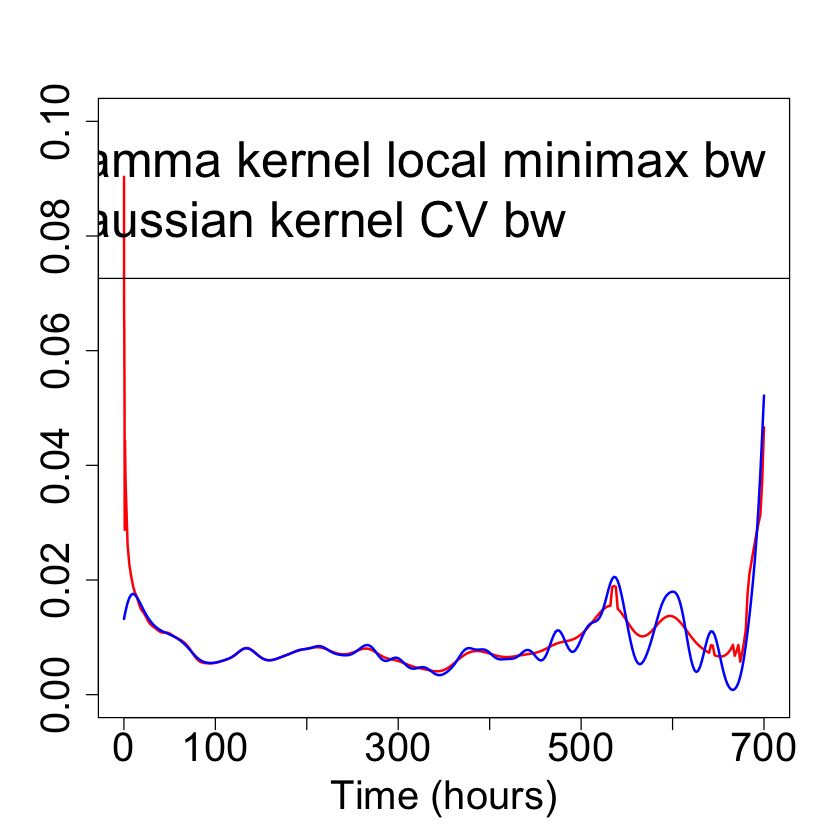

In [4]:
#Testing the adaptive hazard rate estimator on real data (smurf flies)

#pdf(file = "Oracle_smurf.pdf",  width = 15, height = 7.5) 

Grid_exp = c((1:20)/10, (2:350)*2 ) 
RES = minimax_pointwise_data(sort(TS),Grid_exp) #local minimax estimator

par(cex.lab = 2, cex.axis = 2, cex.main = 2)

Kopt = RES$K #adaptive bandwidth estimator
Bopt = RES$B #chosen bandwidths 
B = Bandwidth_set(length(TS))
CV_sm=crossval(sort(TS),(1:40)/10,ker_estg,0)#computing CV for each bandwidth in the set
b_exp = which.min(CV_sm)#CV bandwidth 
est_gaus_exp = sapply(Grid_exp, function(t)(ker_estg(t,TS,b_exp))) #gaussian kernel estimator  
cat('CV bandwidth:',b_exp,'\n')                      
cat('Maximum of the gaussian estimator with CV bw near 0:',max(est_gaus_exp[0:10]),'\n')
cat('Maximum of the gamma estimator with minimax local bw near 0:',max(Kopt[0:10]))

#layout(matrix(c(1,2), 1, 2, byrow = TRUE))
plot(Grid_exp,Kopt, type = 'l',col='red',lwd=2,lty=1,ylim=c(0,0.1),xlab = 'Time (hours)',ylab = NA)
lines(Grid_exp, est_gaus_exp, type = 'l', col='blue',lwd=2)
legend('topright',legend=c('Gamma kernel local minimax bw','Gaussian kernel CV bw'), col=c('red','blue'),lwd=2,cex=2.5)
if(FALSE){
test = sapply(Grid_exp, function(t)(ker_est_gamma_c(t,TS,min(B))))
plot(Grid_exp,  test, col='purple',lty=1,lwd=2,type = 'l',ylim=c(0,0.1),xlab = 'Time (hours)',ylab = NA)   
test = sapply(Grid_exp, function(t)(ker_est_gamma_c(t,TS,max(B))))
lines(Grid_exp,  test, col='black',lty=1,lwd=2,type = 'l',ylim=c(0,0.1),xlab = 'Time (hours)',main = 'Maximum bandwidth',ylab = NA)  
legend('topright',legend=c('Gamma kernel min bw','Gamma kernel max bw'), col=c('purple','black'),lwd=2,cex=2.5)
}
#dev.off()             


# V. Complementary plots to compare estimators (kernel and bandwidth choice methods), in the Appendix of the paper

In [25]:
Grid = (0:600)
#death hazard rate is a+b*exp(-c*t)
a = 7*10^(-3)
b = 3*10^(-2)
c = 7*10^(-2)
th_haz = a+b*exp(-c*Grid)
b3 = 0.5 #bandwidth for log estimator
pop_size = 2000 #Simulated population size
param = list('a' = a, 'b' = b, 'c' = c) 

In [26]:
#estimators for m = 500
BW_CV = (1:150)/3 #set of bandwidths for cross validation

m=500
seed = 1

B5 = Bandwidth_set_global(m) #bandwith set for global minimax bandwidth choice
RES5 = minimax_global(param1,hazard1 , m ,  Grid, B5,seed)#global minimax bandwidth estimator
Bopt_5= RES5$B #chosen bandwidth
Ttest_5 = RES5$T #simulated data
CV5 =crossval(sort(Ttest_5),BW_CV,ker_est_gamma_c,0)#cross validation for gamma kernel
Bopt_cv5 = BW_CV[which.min(CV5)]#minmizer of cross-validation
res_adapt5 = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttest_5,Bopt_5))) #minimax global bandwidth choice estimator
res_CV5 = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttest_5,Bopt_cv5))) #cross-validation bandiwdth estimator

B1 = Bandwidth_set(m)
RES = minimax_pointwise(param1,hazard1 , m ,  Grid, B1,seed)#local minimax bandwidth estimator
Kopt1 = RES$K #adaptive hazard estimator
Bopt1 = RES$B #chosen bandwidth
Ttest1 = RES$T #simulated data
est_band1 = sapply(Grid, function(x)( ker_est_neigh(x,Ttest1,25))) #nearest neighbour bandwidth gaussian kernel estimator 

In [27]:
#estimators for m = 2000
BW_CV = (1:150)/3 #set of bandwidths for cross validation

m=2000 

B2 = Bandwidth_set_global(m)
RES2 = minimax_global(param1,hazard1 , m ,  Grid, B2,seed)
Bopt_2= RES2$B #chosen bandwidth
Ttest_2 = RES2$T #simulated data
CV2 =crossval(sort(Ttest_2),BW_CV,ker_est_gamma_c,0)
Bopt_cv2 = BW_CV[which.min(CV2)]
res_adapt2 = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttest_2,Bopt_2)))
res_CV2 = sapply(Grid, function(t)(ker_est_gamma_c(t,Ttest_2,Bopt_cv2)))

B3 = Bandwidth_set(m)
RES2 = minimax_pointwise(param1,hazard1, m ,  Grid, B3,seed)
Kopt3 = RES2$K
Bopt3 = RES2$B
Ttest3 = RES2$T
est_band3 = sapply(Grid, function(x)( ker_est_neigh(x,Ttest3,60))) #nearest neighbour bandwidth gaussian kernel estimator

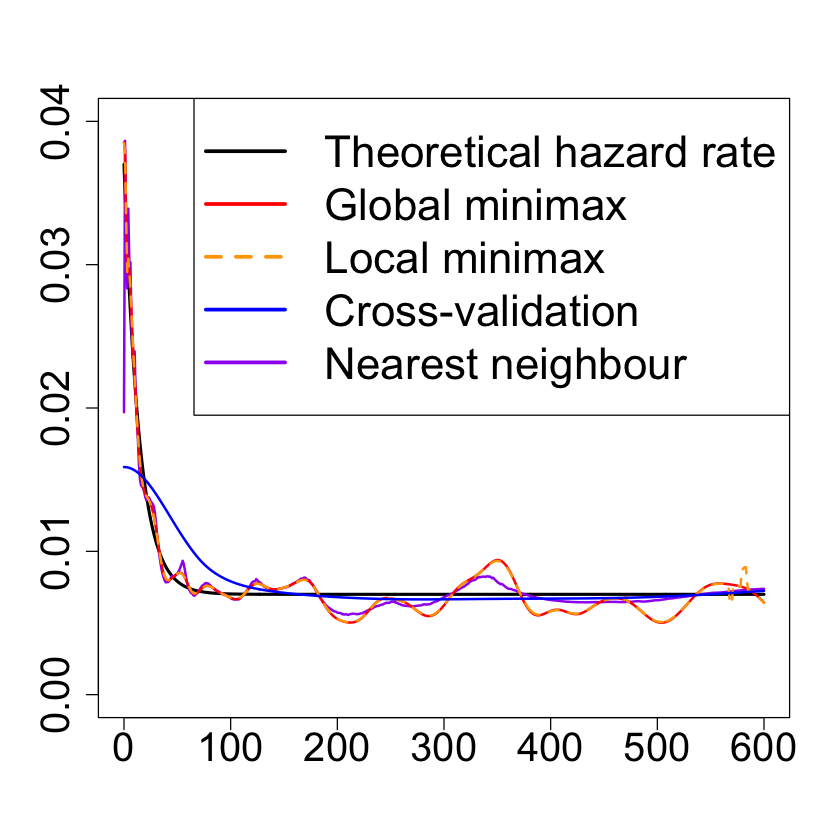

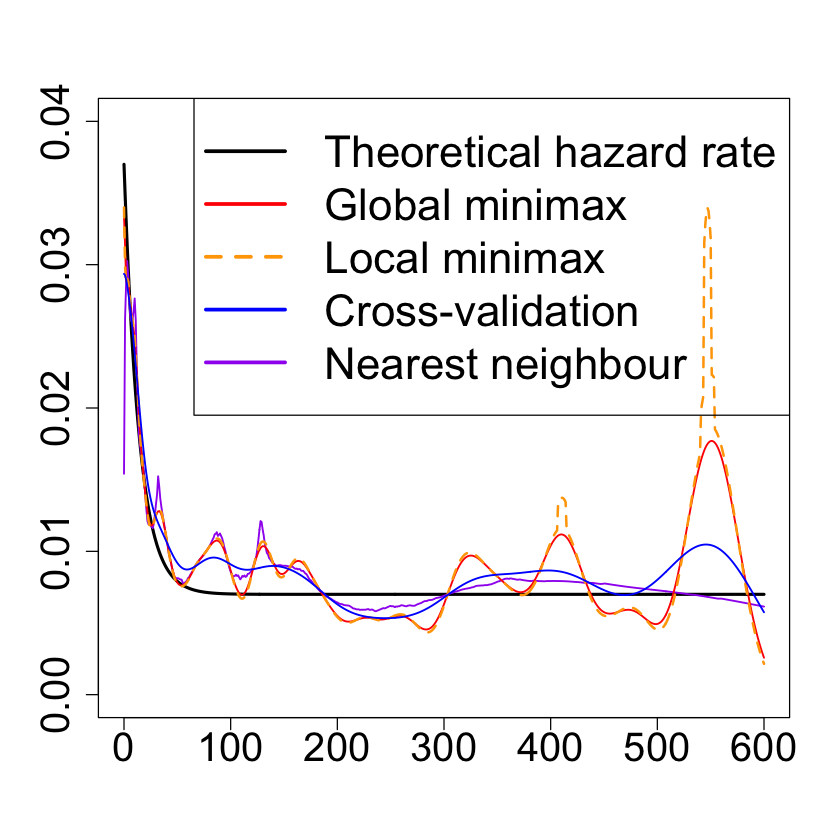

In [32]:
#Plots of the estimators
#pdf(file = "bw_choice_comp2000.pdf",  width = 10, height = 10)  
par(cex.lab = 2, cex.axis = 2,cex.main = 2)
              
plot(Grid,th_haz,type = 'l',col='black',lwd=2.5,ylim = c(0,0.04),xlab = NA, ylab = NA)
lines(Grid, est_band3,lwd=2, col='purple')
lines(Grid,res_adapt2,col='red',type='l',ylim=c(0,0.04),lwd=2)
lines(Grid, Kopt3,type = 'l',col='orange',lty=2,lwd=2)
lines(Grid,res_CV2,lwd=2,col='blue')

legend('topright',legend=c('Theoretical hazard rate','Global minimax',
                           'Local minimax', 'Cross-validation', 'Nearest neighbour'),
        col=c('black','red','orange','blue','purple'), pch=c(NA,NA,NA,NA,NA),lty = c(1,1,2,1,1),lwd=3,cex=2.2)
            
#dev.off()
                
#pdf(file = "bw_choice_comp500.pdf",  width = 10, height = 10)  
par(cex.lab = 2, cex.axis = 2,cex.main = 2)

plot(Grid,th_haz,type = 'l',col='black',lwd=2.5,ylim = c(0,0.04),xlab = NA, ylab = NA)
lines(Grid, est_band1,lwd=1.5, col='purple')
lines(Grid,res_adapt5,col='red',type='l',ylim=c(0,0.08),lwd=1.5)
lines(Grid, Kopt1,type = 'l',col='orange',lty=2,lwd=2)
lines(Grid,res_CV5,lwd=1.5,col='blue')

legend('topright',legend=c('Theoretical hazard rate','Global minimax',
                           'Local minimax', 'Cross-validation', 'Nearest neighbour'),
        col=c('black','red','orange','blue','purple'), pch=c(NA,NA,NA,NA,NA),lty = c(1,1,2,1,1),lwd=3,cex=2.2)
#dev.off()      

# VI. Empirical for CV and nearest neighbour bandwidth with the Gaussian kernel (Appendix of the paper)

In [27]:
BW_CV = (1:150)/3 #set of bandwidths for cross validation
a1 = 7*10^(-3)
b1 = 3*10^(-2)
c1 = 7*10^(-2)
param1 = list('a1'=a1, 'b1' = b1, 'c1' = c1) #parameters as list
Grid = (0:600)
th_haz = a1+b1*exp(-c1*Grid) #theoretical hazard
reps = 50 #number of repetitions for empirical MISE computation

In [28]:
#Code to compute the empirical MISE for the local minimax bandwidth and nearest neighbour bandwidth, takes a while, 
#the following cell allows to just load the results
compute_data = FALSE #set to TRUE to recompute all of the MISE estimations, takes a few hours
if (compute_data){
MISE_gauss_500 = MISE_approx_gaussian(500, reps ,param1, hazard1,th_haz,Grid,25,BW_CV) #last input is number of neighbours for nearest
#neighbour bandwidth 
MISE_500_cvg = rowMeans(MISE_gauss_500$cv[1:grid_max,])
MISE_500_nng = rowMeans(MISE_gauss_500$nn[1:grid_max,])
MISE_500_cv_0g = rowMeans(MISE_gauss_500$cv_0[1:grid_max,])
MISE_500_nn_0g = rowMeans(MISE_gauss_500$nn_0[1:grid_max,])
    
MISE_gauss_1000 = MISE_approx_gaussian(1000, reps ,param1, hazard1,th_haz,Grid,40,BW_CV)
MISE_1000_cvg = rowMeans(MISE_gauss_1000$cv[1:grid_max,])
MISE_1000_nng = rowMeans(MISE_gauss_1000$nn[1:grid_max,])
MISE_1000_cv_0g = rowMeans(MISE_gauss_1000$cv_0[1:grid_max,])
MISE_1000_nn_0g = rowMeans(MISE_gauss_1000$nn_0[1:grid_max,])

MISE_gauss_2000 = MISE_approx_gaussian(2000, reps ,param1, hazard1,th_haz,Grid,60,BW_CV)
MISE_2000_cvg = rowMeans(MISE_gauss_2000$cv[1:grid_max,])
MISE_2000_nng = rowMeans(MISE_gauss_2000$nn[1:grid_max,])
MISE_2000_cv_0g = rowMeans(MISE_gauss_2000$cv_0[1:grid_max,])
MISE_2000_nn_0g = rowMeans(MISE_gauss_2000$nn_0[1:grid_max,])

MISE_gauss_4000 = MISE_approx_gaussian(4000, reps ,param1, hazard1,th_haz,Grid,70,BW_CV)
MISE_4000_cvg = rowMeans(MISE_gauss_4000$cv[1:grid_max,])
MISE_4000_nng = rowMeans(MISE_gauss_4000$nn[1:grid_max,])
MISE_4000_cv_0g = rowMeans(MISE_gauss_4000$cv_0[1:grid_max,])
MISE_4000_nn_0g = rowMeans(MISE_gauss_4000$nn_0[1:grid_max,])
}

In [25]:
#load results 
MISE_500_cvg=rowMeans(read.csv('MISE/MISE_500_cvg.csv')[2:(grid_max+1)])
MISE_500_nng=rowMeans(read.csv('MISE/MISE_500_nng.csv')[2:(grid_max+1)])
MISE_500_cv_0g=rowMeans(read.csv('MISE/MISE_500_cv_0g.csv')[2:(grid_max+1)])
MISE_500_nn_0g=rowMeans(read.csv('MISE/MISE_500_nn_0g.csv')[2:(grid_max+1)])

MISE_1000_cvg=rowMeans(read.csv('MISE/MISE_1000_cvg.csv')[2:(grid_max+1)])
MISE_1000_nng=rowMeans(read.csv('MISE/MISE_1000_nng.csv')[2:(grid_max+1)])
MISE_1000_cv_0g=rowMeans(read.csv('MISE/MISE_1000_cv_0g.csv')[2:(grid_max+1)])
MISE_1000_nn_0g=rowMeans(read.csv('MISE/MISE_1000_nn_0g.csv')[2:(grid_max+1)])

MISE_2000_cvg=rowMeans(read.csv('MISE/MISE_2000_cvg.csv')[2:(grid_max+1)])
MISE_2000_nng=rowMeans(read.csv('MISE/MISE_2000_nng.csv')[2:(grid_max+1)])
MISE_2000_cv_0g=rowMeans(read.csv('MISE/MISE_2000_cv_0g.csv')[2:(grid_max+1)])
MISE_2000_nn_0g=rowMeans(read.csv('MISE/MISE_2000_nn_0g.csv')[2:(grid_max+1)])

MISE_4000_cvg=rowMeans(read.csv('MISE/MISE_4000_cvg.csv')[2:(grid_max+1)])
MISE_4000_nng=rowMeans(read.csv('MISE/MISE_4000_nng.csv')[2:(grid_max+1)])
MISE_4000_cv_0g=rowMeans(read.csv('MISE/MISE_4000_cv_0g.csv')[2:(grid_max+1)])
MISE_4000_nn_0g=rowMeans(read.csv('MISE/MISE_4000_nn_0g.csv')[2:(grid_max+1)])

In [26]:
#print results
print('500 ')
cat(' nn : ',mean(MISE_500_nng),' ',sd(MISE_500_nng),' nn 0: ',mean(MISE_500_nn_0g),' ', sd(MISE_500_nn_0g),'\n')
cat(' cv: ', mean(MISE_500_cvg),' ',sd(MISE_500_cvg),' cv 0: ', mean(MISE_500_cv_0g), ' ', sd(MISE_500_cv_0g),'\n')
print('1000 ')
cat(' nn : ',mean(MISE_1000_nng),' ',sd(MISE_1000_nng),' nn 0: ',mean(MISE_1000_nn_0g),' ', sd(MISE_1000_nn_0g),'\n')
cat(' cv: ', mean(MISE_1000_cvg),' ',sd(MISE_1000_cvg),' cv 0: ', mean(MISE_1000_cv_0g), ' ', sd(MISE_1000_cv_0g),'\n')
print('2000 ')
cat(' nn : ',mean(MISE_2000_nng),' ',sd(MISE_2000_nng),' nn 0: ',mean(MISE_2000_nn_0g),' ', sd(MISE_2000_nn_0g),'\n')
cat(' cv: ', mean(MISE_2000_cvg),' ',sd(MISE_2000_cvg),' cv 0: ', mean(MISE_2000_cv_0g), ' ', sd(MISE_2000_cv_0g),'\n')
print('4000 ')
cat(' nn : ',mean(MISE_4000_nng),' ',sd(MISE_4000_nng),' nn 0: ',mean(MISE_4000_nn_0g),' ', sd(MISE_4000_nn_0g),'\n')
cat(' cv: ', mean(MISE_4000_cvg),' ',sd(MISE_4000_cvg),' cv 0: ', mean(MISE_4000_cv_0g), ' ', sd(MISE_4000_cv_0g),'\n')

[1] "500 "
 nn :  2.758025e-06   1.288987e-06  nn 0:  0.0003767868   0.0001260366 
 cv:  1.374181e-05   4.300191e-06  cv 0:  0.0008896975   7.967202e-05 
[1] "1000 "
 nn :  1.803481e-06   6.069724e-07  nn 0:  0.0003533572   9.009934e-05 
 cv:  1.225683e-05   3.39843e-06  cv 0:  0.0008592621   0.0001424433 
[1] "2000 "
 nn :  1.328001e-06   3.055565e-07  nn 0:  0.0003582882   7.486174e-05 
 cv:  1.226677e-05   8.783876e-06  cv 0:  0.0008564558   0.0001423199 
[1] "4000 "
 nn :  1.222845e-06   3.37576e-07  nn 0:  0.0003545749   6.812285e-05 
 cv:  1.041076e-05   2.269777e-06  cv 0:  0.0008670811   0.0001231937 
